In [3]:
# Import packages
import numpy as np
import skimage.io as skio
import skimage.morphology as skm
from skimage import feature
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import opendatasets as od
import os
import torch
import cv2
import math
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Concatenate, Conv2D,Conv3D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, UpSampling3D, BatchNormalization, UpSampling2D
from tensorflow.keras.optimizers.legacy import Adam

from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

# data = od.download("https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset")

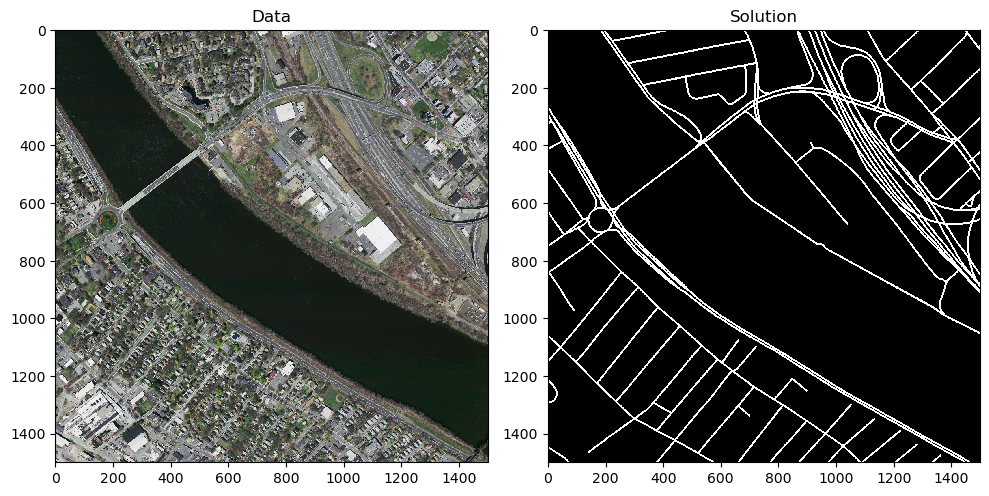

In [4]:
# Read the data
rgb = skio.imread("./Massachusetts-roads-dataset/tiff/train/10828735_15.tiff")
ans = skio.imread("./Massachusetts-roads-dataset/tiff/train_labels/10828735_15.tif")

# Display training data and correct output
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(rgb, ax = ax[0])
ax[0].set_title("Data")
skio.imshow(ans, ax = ax[1])
ax[1].set_title("Solution");


In [5]:
DATA_DIR = './massachusetts-roads-dataset/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [6]:
class_dict = pd.read_csv("./massachusetts-roads-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)


All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [7]:
# image paths
image_paths = [os.path.join(x_train_dir, image_id) for image_id in sorted(os.listdir(x_train_dir))]
mask_paths = [os.path.join(y_train_dir, image_id) for image_id in sorted(os.listdir(y_train_dir))]

In [ ]:
val paths
image_paths = [os.path.join(x_train_dir, image_id) for image_id in sorted(os.listdir(x_train_dir))]
mask_paths = [os.path.join(y_train_dir, image_id) for image_id in sorted(os.listdir(y_train_dir))]

In [8]:
# prep image training 
train_len = 100

train_img = [0] * train_len
train_masks = [0] * train_len
for i in range(train_len):
    # read images for each path
    train_img[i] = cv2.imread(image_paths[i])
    train_masks[i] = cv2.imread(mask_paths[i])


In [9]:
train_img = np.array(train_img[2:])
train_img = train_img[:, :1024, :1024,:]
train_masks = np.array(train_masks[:98])
train_masks = train_masks[:, :1024, :1024]

print(train_img.shape)
print(train_masks.shape)

(98, 1024, 1024, 3)
(98, 1024, 1024, 3)


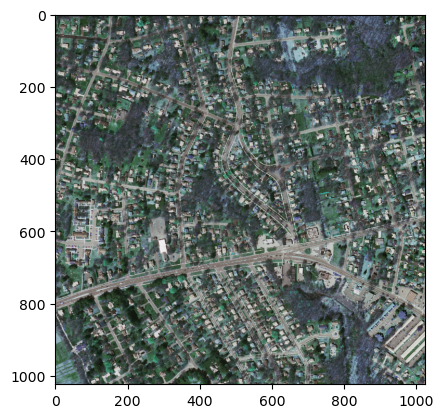

In [10]:
plt.imshow(train_img[30])

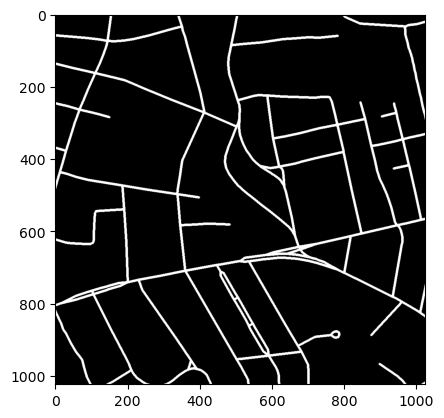

In [11]:
plt.imshow(train_masks[30])

In [12]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [13]:
# I found this architecture with the shape (512, 512, 1). 

def unet(input_size = (1024,1024,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    print(tf.size(conv1))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2DTranspose(512,2,strides=(2,2),padding='same')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(256,2,strides=(2,2),padding='same')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(128,2,strides=(2,2),padding='same')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2DTranspose(64,2,strides=(2,2),padding='same')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=[dice_coef])

    model.summary()
    return model

In [14]:
model = unet()

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.int32, name=None), inferred_value=[None], name='tf.compat.v1.size/Size:0', description="created by layer 'tf.compat.v1.size'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1024, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1024, 1024, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_model.h5', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

# Train the model
history = model.fit(x=train_img, y=train_masks[:,:,:,0], epochs = 1, batch_size=1, validation_data=(X_val, y_val), callbacks=callbacks)


In [ ]:
model.fit(